In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import warnings

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax
from itertools import product

import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"
CHIMP_DATASET_PATH = f"{_BASE_URL}/chimpanzees.csv"

In [3]:
chimp_data = pd.read_csv(CHIMP_DATASET_PATH, sep=";")

In [4]:
chimp_data["treatment"] = chimp_data["prosoc_left"] + 2 * chimp_data["condition"]

In [5]:
chimp_data.keys()

Index(['actor', 'recipient', 'condition', 'block', 'trial', 'prosoc_left',
       'chose_prosoc', 'pulled_left', 'treatment'],
      dtype='object')

In [6]:
# 'a' is an intercept. Wnuniquewill construct actor specific intercepts in a subsequent
# model
actor_idx, actors = pd.factorize(chimp_data["actor"])
treat_idx, treatments = pd.factorize(chimp_data["treatment"])

models = {}
for w1, w2 in product([10, 0.5], [10, 0.5]):
    # for w1, w2 in product([0.1], [10, 0.5]):
    model_name = f"w1={w1:.1f}:w2={w2:.1f}"
    print(model_name)
    with pm.Model() as model:
        a = pm.Normal("a", 0, w1, shape=len(actors))
        b = pm.Normal("b", 0, w2, shape=len(treatments))

        actor_id = pm.intX(pm.Data("actor_id", actor_idx))
        treat_id = pm.intX(pm.Data("treat_id", treat_idx))

        p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))
        pulled_left = pm.Binomial(
            "pulled_left", 1, p, observed=chimp_data["pulled_left"]
        )

    with model:
        trace = pm.sample(1000, tune=1000)
        prior = pm.sample_prior_predictive(1000)
        posterior_predictive = pm.sample_posterior_predictive(
            trace, var_names=["p", "pulled_left"]
        )

    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords={"treatment": chimp_data["treatment"], "actor": chimp_data["actor"]},
    )
    # generated quantity
    ppp_at_coords = {}
    for coord in pm_data.prior["b"].coords["b_dim_0"].values:
        ppp_at_coords[coord] = logistic(
            pm_data.prior["a"] + pm_data.prior["b"].sel(b_dim_0=coord)
        )
    models[model_name] = {
        "model": model,
        "pm_data": pm_data,
        "w1": w1,
        "w2": w2,
        "ppp_at_coords": ppp_at_coords,
    }

w1=10.0:w2=10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:22<00:00, 87.64it/s] 
The acceptance probability does not match the target. It is 0.8798759742427139, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 2000/2000 [00:03<00:00, 588.24it/s]


w1=10.0:w2=0.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
Sampling chain 1, 5 divergences: 100%|██████████| 2000/2000 [00:08<00:00, 238.70it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 2000/2000 [00:03<00:00, 580.30it/s]


w1=0.5:w2=10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:03<00:00, 609.89it/s]


w1=0.5:w2=0.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
100%|██████████| 2000/2000 [00:03<00:00, 577.20it/s]


In [7]:
m = models.get("w1=10.0:w2=10.0")
m["ppp_at_coords"][0].values.flatten()

array([1.        , 0.01333646, 0.99999506, ..., 0.99999996, 0.05649954,
       0.9999986 ])

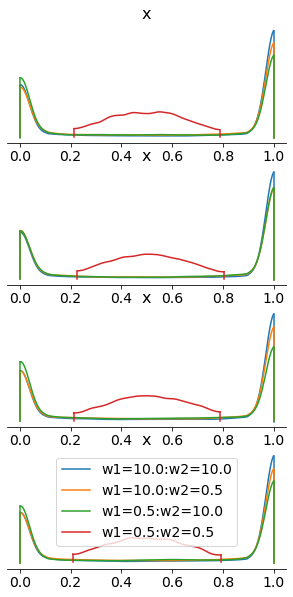

In [8]:
# Plot the prior predictive for each coordinate
fig = plt.figure(figsize=(5, 10))
axes = fig.subplots(chimp_data["treatment"].nunique(), 1)

for i, ax in enumerate(axes):
    #    print(i)
    az.plot_density(
        [m["ppp_at_coords"][i].values.flatten() for m in models.values()],
        data_labels=list(models.keys()),
        group="prior",
        point_estimate=None,
        ax=ax,
    )
    if i < 3:
        ax.get_legend().remove()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d9c6eeed0>],
      dtype=object)

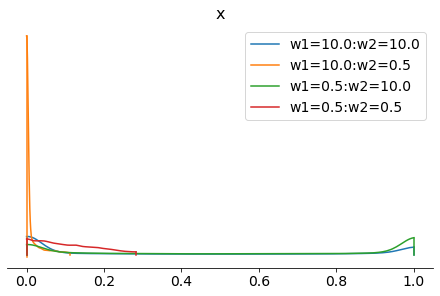

In [9]:
# plot the prior predictictive for a contrast
az.plot_density(
    [
        np.abs(
            m["ppp_at_coords"][1].values.flatten()
            - m["ppp_at_coords"][0].values.flatten()
        )
        for m in models.values()
    ],
    data_labels=list(models.keys()),
    group="prior",
    point_estimate=None,
)

In [10]:
with models["w1=0.5:w2=0.5"]["model"]:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    p_post = pm.sample_posterior_predictive(trace, var_names=["p"],)["p"]
p_mu = p_post.mean(0).reshape((7, 4))

100%|██████████| 2000/2000 [00:01<00:00, 1041.81it/s]


In [11]:
models["w1=0.5:w2=0.5"]["model"]

/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (28). Passed array should have shape (chains, draws, *shape)
  UserWarning,


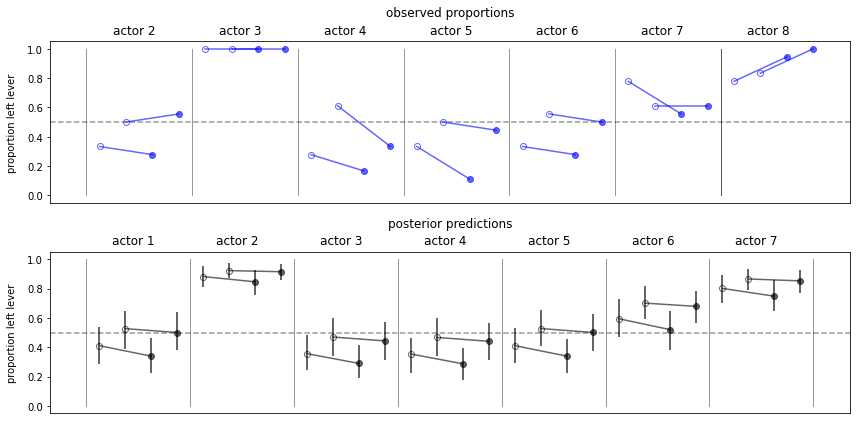

In [12]:
pl = chimp_data.groupby(["actor", "treatment"]).agg("mean")["pulled_left"].unstack()
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    actor += 1
    ax0.plot(
        [actor * 4, actor * 4 + 2],
        [pl.loc[actor, 0], pl.loc[actor, 2]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [pl.loc[actor, 1], pl.loc[actor, 3]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4, actor * 4 + 1],
        [pl.loc[actor, 0], pl.loc[actor, 1]],
        "o",
        c="b",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [pl.loc[actor, 2], pl.loc[actor, 3]],
        "o",
        c="b",
        ms=6,
        alpha=alpha,
    )
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    if actor == 0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")
ax0.set_xticks([])
ax0.set_ylabel("proportion left lever", labelpad=10)
ax0.set_title("observed proportions", pad=25)

ax1.plot([range(28), range(28)], az.hpd(p_post).T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax1.plot(
        [actor * 4, actor * 4 + 2],
        [p_mu[actor, 0], p_mu[actor, 2]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [p_mu[actor, 1], p_mu[actor, 3]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4, actor * 4 + 1],
        [p_mu[actor, 0], p_mu[actor, 1]],
        "o",
        c="k",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [p_mu[actor, 2], p_mu[actor, 3]],
        "o",
        c="k",
        ms=6,
        alpha=alpha,
    )
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
ax1.set_xticks([])
ax1.set_ylabel("proportion left lever", labelpad=10)
ax1.set_title("posterior predictions", pad=25)
plt.tight_layout();

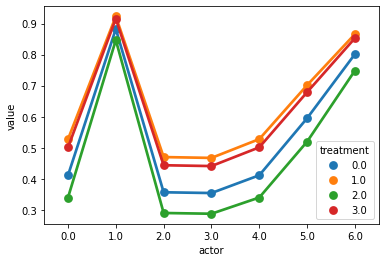

In [13]:
# alternative method for summarizing the data.
samples = pd.DataFrame(np.vstack(models["w1=0.5:w2=0.5"]["pm_data"].posterior["p"]).T)
samples["treatment"] = models["w1=0.5:w2=0.5"]["pm_data"].constant_data.treat_id
samples["actor"] = models["w1=0.5:w2=0.5"]["pm_data"].constant_data.actor_id
samples_long_form = samples.melt(id_vars=["treatment", "actor"])
sns.pointplot(x="actor", y="value", hue="treatment", data=samples_long_form)